In [1]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# ! pip3 install lightning mlflow
# ! pip3 install matplotlib

In [2]:
import os
import sys
import torch 
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

import torch
from torch.utils.data import DataLoader, random_split
torch.set_float32_matmul_precision('high')

import mlflow.pytorch

import pytorch_lightning as pl
from lightning.pytorch.loggers import MLFlowLogger



In [3]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [4]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
IS_HOUR = False
RANDOM_STATE = 1
PAST_WINDOW = 7
if IS_HOUR:
    PAST_WINDOW *= 24
FUTURE_WINDOW = 30
if IS_HOUR:
    FUTURE_WINDOW *= 24
BATCH_SIZE = 2048*16
ROLLING_WINDOW = 365
if IS_HOUR:
    ROLLING_WINDOW *= 24


DATE_COLUMNS = ['year','month','day','hour'] if IS_HOUR else ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]
MODEL_INPUT_FEATURES = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']




def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

# load datset

In [5]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    if not IS_HOUR:
        regions_df[region].drop('hour', axis=1, inplace=True)
        # group by daily and average
        regions_df[region] = regions_df[region].groupby('date').mean()
    else:
        # set datetime index 
        regions_df[region] = regions_df[region].set_index('date')

    # # add 1-hot week info
    # week_df = regions_df[region].index.to_series().dt.isocalendar().week
    # week_df = pd.get_dummies(week_df,prefix='week')
    # regions_df[region] = pd.concat([regions_df[region],week_df], axis=1)

    # calulate rolling mean
    regions_df[region][POLUTION_FEATURES] = regions_df[region][POLUTION_FEATURES].rolling(ROLLING_WINDOW).mean()
    regions_df[region] = regions_df[region].dropna()

    # add 1-hot month info
    month_df = regions_df[region].index.to_series().dt.month
    month_df = pd.get_dummies(month_df,prefix='month')
    regions_df[region] = pd.concat([regions_df[region],month_df], axis=1)
del region

In [6]:
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2014-02-28,88.246096,116.907484,29.004121,64.009159,1293.268511,42.436491,1.625000,1020.383333,-4.270833,0.0,...,False,False,False,False,False,False,False,False,False,False
2014-03-01,88.448379,117.141959,29.077865,64.106191,1296.168054,42.357990,5.933333,1017.437500,-11.258333,0.0,...,True,False,False,False,False,False,False,False,False,False
2014-03-02,88.740274,117.482598,29.168619,64.173314,1300.985634,42.314726,4.304167,1016.508333,-5.066667,0.0,...,True,False,False,False,False,False,False,False,False,False
2014-03-03,89.143242,117.847553,29.316221,64.220346,1308.817255,42.267808,1.875000,1016.112500,-2.608333,0.0,...,True,False,False,False,False,False,False,False,False,False
2014-03-04,89.244155,117.918215,29.334900,64.201051,1310.463320,42.242922,4.795833,1020.775000,-14.537500,0.0,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,80.120149,100.003919,10.780051,51.718629,1233.937840,62.992626,5.166667,1021.012500,-11.141667,0.0,...,False,False,False,False,False,False,False,False,False,False
2017-02-25,80.058733,99.892047,10.763841,51.746597,1233.093091,63.022763,7.245833,1018.812500,-10.754167,0.0,...,False,False,False,False,False,False,False,False,False,False
2017-02-26,80.079510,99.920585,10.767494,51.851277,1233.481219,63.003368,7.208333,1020.337500,-8.258333,0.0,...,False,False,False,False,False,False,False,False,False,False


<Axes: >

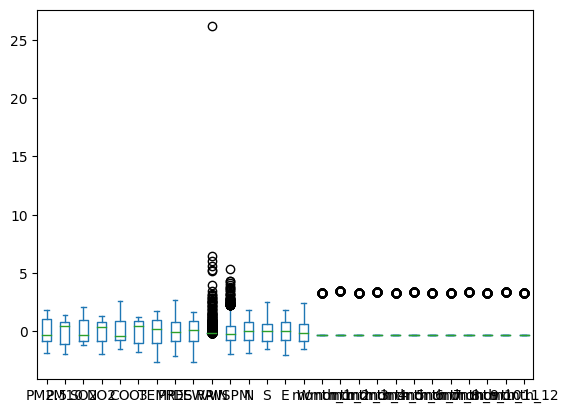

In [7]:
((regions_df[Region.AOTIZHONGXIN] - regions_df[Region.AOTIZHONGXIN].mean())/(regions_df[Region.AOTIZHONGXIN].std())).plot(kind="box")

In [8]:
def get_test_feature_targets(df:pd.DataFrame, feature:str, split_date:str='2016-03-01 00:00:00'):
    return df[df.index >= split_date][feature].tolist()

# Deep Learning

In [9]:
from torch import Tensor
from numpy import concatenate, clip
from torch.utils.data import Dataset
from numpy.lib.stride_tricks import sliding_window_view

class FeatureForcastingDataset(Dataset):
    def __init__(self, df:pd.DataFrame, pred_feature:str, past_window:int, future_window:int, model_features:list=MODEL_INPUT_FEATURES, split_date:str='2016-03-01 00:00:00', is_train:bool=True):  
        self.pred_feature = pred_feature
        self.model_features = model_features
        self.past_window = past_window
        self.future_window = future_window
        # split to train and test 
        df = df[df.index < split_date] if is_train else df[df.index >= split_date] 
        # normalize
        norm_feature_df = df[self.model_features] 
        self.mean = norm_feature_df.mean()
        self.std = norm_feature_df.std()
        norm_feature_df = ( norm_feature_df - self.mean ) / self.std
        # build sliding window for features
        dataset_window = past_window + future_window
        features_df = []
        for feature in self.model_features:
            feature_df = sliding_window_view(norm_feature_df[feature], window_shape=dataset_window)[:,:-self.future_window]
            features_df.append(feature_df)
        features = concatenate(features_df, axis=1)
        del features_df
        # build 1-hot encoding for month 
        month_col = [f"month_{index}" for index in range(1,13)]
        month_df = clip(sliding_window_view(df[month_col], window_shape=dataset_window, axis=0)[:,:,:-future_window].sum(axis=2),None,1)
        # build targets
        target = sliding_window_view(norm_feature_df[self.pred_feature ], window_shape=dataset_window)[:,-1:]
        # build datset
        features = concatenate([features,month_df],axis=1)
        self.features = Tensor(features)
        self.targets = Tensor(target)
        # discard variables
        del df
        del feature
        del feature_df
        del dataset_window
        del month_col
        del month_df

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]
    
datset = FeatureForcastingDataset(regions_df[Region.AOTIZHONGXIN],MODEL_INPUT_FEATURES[0],PAST_WINDOW,FUTURE_WINDOW,is_train=True)
datset[0]

/tmp/ipykernel_644881/1125800742.py:35: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  self.targets = Tensor(target)


(tensor([ 0.8457,  0.8849,  0.9414,  1.0194,  1.0389,  0.9708,  0.8597,  0.2709,
          0.3275,  0.4097,  0.4977,  0.5148,  0.4168,  0.2588,  1.7318,  1.7457,
          1.7628,  1.7907,  1.7942,  1.7534,  1.6998,  1.0808,  1.1318,  1.1670,
          1.1917,  1.1816,  1.0561,  0.8959,  0.8648,  0.9118,  0.9899,  1.1168,
          1.1434,  1.0669,  0.9516, -1.2803, -1.2907, -1.2964, -1.3026, -1.3058,
         -1.3177, -1.3058, -1.0916, -0.6960, -0.8456, -1.0686, -0.8005, -1.0300,
         -0.9137,  0.7948,  0.5078,  0.4173,  0.3787,  0.8330,  1.0023,  1.1233,
         -0.5290, -1.0426, -0.5875, -0.4068, -1.2837, -1.3918, -1.6561, -0.2663,
         -0.2663, -0.2663, -0.2663, -0.2663, -0.2663, -0.2663, -0.4344,  0.4890,
         -0.0869, -0.4500,  1.1322,  0.6602,  0.7587,  0.0000,  1.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000]),
 tensor([0.5897]))

In [10]:
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError

class FeatureForecastingModel(pl.LightningModule):
    def __init__(self, model_features:list=MODEL_INPUT_FEATURES, past_window:int=1, future_window:int=1, hidden_layer_size:int=2048, hidden_layers:int=3):
        super(FeatureForecastingModel, self).__init__()
        
        # init model features
        self.past_window = past_window
        self.future_window = future_window
        self.hidden_layers = hidden_layers
        self.hidden_layer_size = hidden_layer_size

        layer_list = []

        # building input layer
        layer_list.append(nn.Linear(in_features=(len(model_features)*self.past_window)+12, out_features=self.hidden_layer_size))
        layer_list.append(nn.ReLU())
        # building hidden layers
        for h_layer in range(self.hidden_layers):
            layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=self.hidden_layer_size))
            layer_list.append(nn.ReLU())
        # building ouput layer
        layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=1))

        # build model
        self.layers = nn.Sequential(*layer_list)
        
        # metics
        self.r2_score = R2Score()
        self.mae = MeanAbsoluteError()
        self.rmse = MeanSquaredError(squared=False)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # Flatten the input images
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.r2_score(y_hat, y)
        self.log('r2_score', self.r2_score, on_epoch=True)
        self.mae(y_hat, y)
        self.log('mae', self.mae, on_epoch=True)
        self.rmse(y_hat, y)
        self.log('rmse', self.rmse, on_epoch=True)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01)


In [11]:
mlflow.get_artifact_uri()

'file:///home/mutakabbir/Projects/federated-airquality-modeling/notebooks/mlruns/0/e1ecef4065df466bbb1d4fc9120e6141/artifacts'

In [12]:
# Auto log all MLflow entities
mlflow.pytorch.autolog()
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("AQL-MM-DL-MA-M")

models = {}


try:
    mlflow.end_run()
except:
    print("No active ML Runs")

# Train the models
with mlflow.start_run() as parent_run:
    parent_run_id = parent_run.info.run_id

    for feature in MODEL_INPUT_FEATURES:
        # Build Bataset
        train_dataset = FeatureForcastingDataset(regions_df[Region.AOTIZHONGXIN],feature, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=True)
        val_dataset = FeatureForcastingDataset(regions_df[Region.AOTIZHONGXIN],feature, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=False)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)

        # build model
        models[feature] = FeatureForecastingModel(past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, hidden_layer_size=128, hidden_layers=2)

        # Create PyTorch Lightning trainer
        trainer = pl.Trainer(
            max_epochs=999,
            accelerator="gpu", 
            logger=False,
            enable_progress_bar=True,
            enable_checkpointing=False,
            devices=1  # Set the number of GPUs to use (change to 2, 3, etc., if available)
        )
        # log model into mlflow
        with mlflow.start_run(nested=True) as nested_run:
            nested_run_id = nested_run.info.run_id

            mlflow.log_param("feature", feature)
            # Train the model
            trainer.fit(models[feature], train_dataloaders=train_loader, val_dataloaders=val_loader)
            trainer.validate(models[feature], val_loader)



2023/06/05 17:02:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:02:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."


No active ML Runs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Total estimated model params size (MB)


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]                   

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

2023/06/05 17:09:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 17:09:10 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/06/05 17:09:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.7963029742240906     │
│         r2_score          │    -0.4022095203399658    │
│           rmse            │    1.1879730224609375     │
│         val_loss          │    1.4112800359725952     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:09:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

2023/06/05 17:16:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 17:16:46 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.6855593323707581     │
│         r2_score          │   -0.18577539920806885    │
│           rmse            │    0.8471258878707886     │
│         val_loss          │    0.7176222205162048     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:16:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

2023/06/05 17:24:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 17:24:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.6334793567657471     │
│         r2_score          │    0.5189177989959717     │
│           rmse            │    0.6974130868911743     │
│         val_loss          │    0.4863849878311157     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:24:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

2023/06/05 17:31:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 17:31:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.6940991878509521     │
│         r2_score          │   -0.024356842041015625   │
│           rmse            │    0.7969752550125122     │
│         val_loss          │    0.6351695656776428     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:31:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

2023/06/05 17:39:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 17:39:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │     0.921133279800415     │
│         r2_score          │   -0.22657406330108643    │
│           rmse            │    1.0577739477157593     │
│         val_loss          │    1.1188856363296509     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:39:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

2023/06/05 17:46:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 17:46:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    1.1037575006484985     │
│         r2_score          │   -0.46195828914642334    │
│           rmse            │    1.2252432107925415     │
│         val_loss          │     1.501220941543579     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:46:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

2023/06/05 17:54:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 17:54:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.4573240876197815     │
│         r2_score          │    0.7220532894134521     │
│           rmse            │    0.5446393489837646     │
│         val_loss          │    0.2966320216655731     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 17:54:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

2023/06/05 18:02:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 18:02:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │     0.808728039264679     │
│         r2_score          │    0.06447446346282959    │
│           rmse            │    0.9890968203544617     │
│         val_loss          │    0.9783124923706055     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 18:02:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

2023/06/05 18:09:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 18:09:57 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.5799250602722168     │
│         r2_score          │    0.47624778747558594    │
│           rmse            │    0.7211558818817139     │
│         val_loss          │    0.5200658440589905     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 18:09:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

2023/06/05 18:17:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 18:17:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.4126020073890686     │
│         r2_score          │   -0.044065237045288086   │
│           rmse            │    1.0735361576080322     │
│         val_loss          │    1.1524797677993774     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 18:17:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 44.7 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Tota

Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]                    

`Trainer.fit` stopped: `max_epochs=999` reached.


Epoch 998: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

2023/06/05 18:25:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 18:25:06 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │     0.899865448474884     │
│         r2_score          │    -0.4486405849456787    │
│           rmse            │     1.174009084701538     │
│         val_loss          │     1.378297209739685     │
└───────────────────────────┴───────────────────────────┘

In [13]:
# load model

import mlflow

mlflow.set_tracking_uri("http://localhost:5001")

run_name = "7f9bd7c6b2f34d1d8d6d872dd0f121ed"
model_uri = f"runs:/{run_name}/model"
loaded_model = mlflow.pytorch.load_model(model_uri)
loaded_model


FeatureForecastingModel(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (r2_score): R2Score()
  (mae): MeanAbsoluteError()
  (rmse): MeanSquaredError()
)

In [14]:
from datetime import datetime, timedelta

def get_1_hot_week(start):
    start_week = start.isocalendar().week
    end_week = (start + timedelta(hours=PAST_WINDOW)).isocalendar().week
    one_hot = []
    for week in range(1,13):
        if (week >= start_week) and (week <= end_week):
            one_hot.append(1)
        else:
            one_hot.append(0)
    return one_hot

start_time = datetime(year=2016, month=3, day=1,hour=0)

print(f"start_week: {start_time.isocalendar().week}")

one_hot = get_1_hot_week(start_time)
print(f"one_hot({len(one_hot)}): {one_hot}")


start_week: 9
one_hot(12): [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [15]:
# get test data 
feature = 'PM2.5'
test_dataset = FeatureForcastingDataset(regions_df[Region.AOTIZHONGXIN],feature, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=False)


# get first input
start_time = datetime(year=2016, month=3, day=1,hour=0)
# feature_past = test_dataset[0][0][:PAST_WINDOW].numpy().tolist()
# month_1_hot = get_1_hot_week(start_time)
# X = torch.Tensor(feature_past+month_1_hot)

# generate target 
y_taget = get_test_feature_targets(regions_df[Region.AOTIZHONGXIN], feature="PM2.5", split_date='2016-03-01 00:00:00')

# generate predictions
index = 0
y_predict = test_dataset[0][0][:PAST_WINDOW].numpy().tolist() 
y_predict
while len(y_predict) < len(y_taget):
    loaded_model.eval()
    feature_past = y_predict[index:index+PAST_WINDOW]
    start_date = start_time + timedelta(hours=index)
    month_1_hot = get_1_hot_week(start_date)
    input = torch.Tensor(feature_past+month_1_hot)
    feature_prediction = loaded_model(input)[0].item()
    y_predict.append(feature_prediction)
    index += 1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x19 and 13x128)

<Axes: >

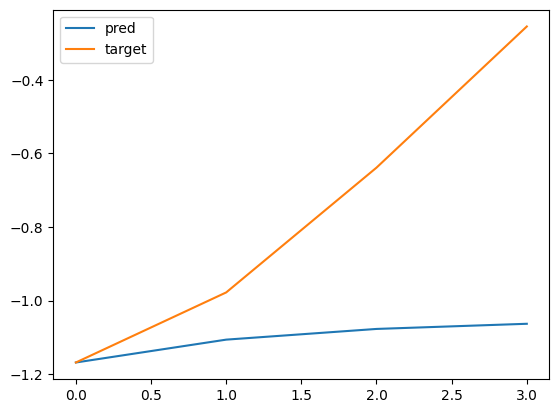

In [ ]:
prediction_df = pd.DataFrame(data ={'pred':y_predict,'target':y_taget})
prediction_df['target'] = (prediction_df['target'] - test_dataset.mean) / test_dataset.std
prediction_df[:4].plot()

<Axes: >

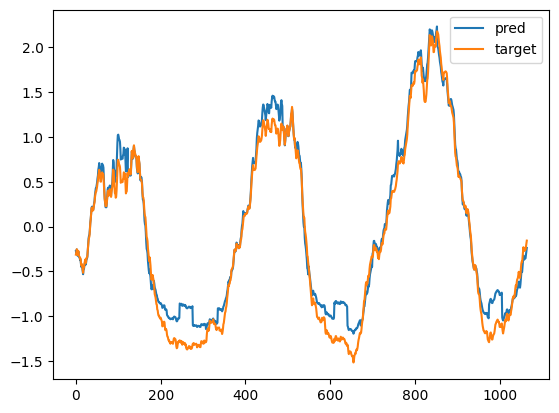

In [ ]:

y_pred = []
y_target = []

for x, y in train_loader:
    y_target += y.reshape((1,-1))[0].numpy().tolist()
    y_pred += models[feature](x).reshape((1,-1))[0].detach().numpy().tolist()

prediction_df = pd.DataFrame(data ={'pred':y_pred[1:],'target':y_target[:-1]})
# prediction_df['target'] = (prediction_df['target'] - test_dataset.mean) / test_dataset.std
prediction_df['target'] = prediction_df['target'] - 0.1
prediction_df[:365*3].plot()   


In [ ]:
feature = 'PM2.5'

# Build Bataset
train_dataset = FeatureForcastingDataset(regions_df[Region.AOTIZHONGXIN],feature, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=True)
val_dataset = FeatureForcastingDataset(regions_df[Region.AOTIZHONGXIN],feature, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)

# build model
models[feature] = FeatureForecastingModel(past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, hidden_layer_size=128, hidden_layers=2)

# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu", 
    logger=False,
    enable_progress_bar=True,
    enable_checkpointing=False,
    devices=1  # Set the number of GPUs to use (change to 2, 3, etc., if available)
)
# log model into mlflow
with mlflow.start_run(nested=True) as nested_run:
    nested_run_id = nested_run.info.run_id

    mlflow.log_param("feature", feature)
    # Train the model
    trainer.fit(models[feature], train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.validate(models[feature], val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/05 01:58:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 37.9 K
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Tota

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]                    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

2023/06/05 01:59:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/05 02:00:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.11431176215410233    │
│         r2_score          │    0.9735116958618164     │
│           rmse            │    0.16258953511714935    │
│         val_loss          │   0.026435356587171555    │
└───────────────────────────┴───────────────────────────┘

<Axes: >

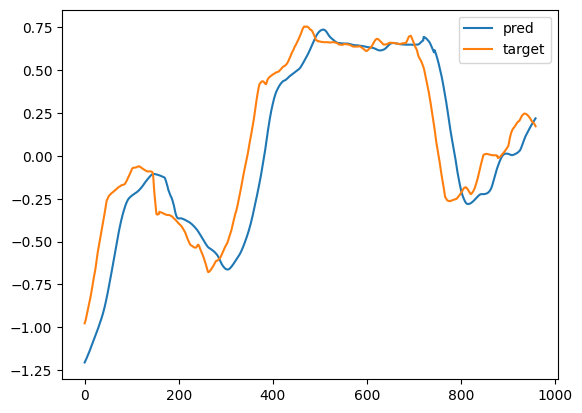

In [ ]:
y_pred = []
y_target = []

for x, y in val_dataset:
    y_pred.append(models[feature](x).item())
    y_target.append(y.item())

prediction_df = pd.DataFrame(data ={'pred':y_pred,'target':y_target})
# prediction_df['target'] = (prediction_df['target'] - test_dataset.mean) / test_dataset.std
prediction_df[:24*40].plot() 